In [68]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import os

In [69]:
num_skipped = 0
for folder_name in ("bike","car"):
    folder_path = os.path.join("Datasets", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try: 
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally: 
            fobj.close()
        
        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [70]:
# Generate a Dataset
image_size = (180,180)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets",
    validation_split=0.1,   
    subset = "training", 
    seed = 1337,   
    image_size = image_size,     
    batch_size = batch_size, 
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Datasets", 
    validation_split = 0.1, 
    subset = "validation", 
    seed = 1337,
    image_size = image_size,
    batch_size = batch_size,
)

Found 951 files belonging to 3 classes.
Using 856 files for training.
Found 951 files belonging to 3 classes.
Using 95 files for validation.


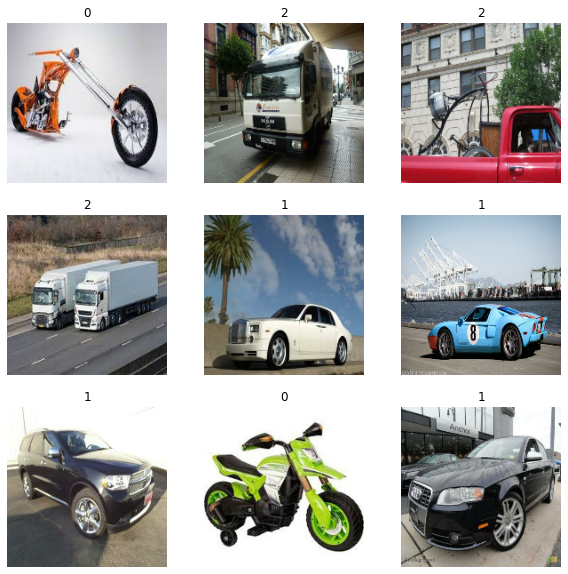

In [71]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [72]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),   
        layers.RandomRotation(0.1),
    ]
)

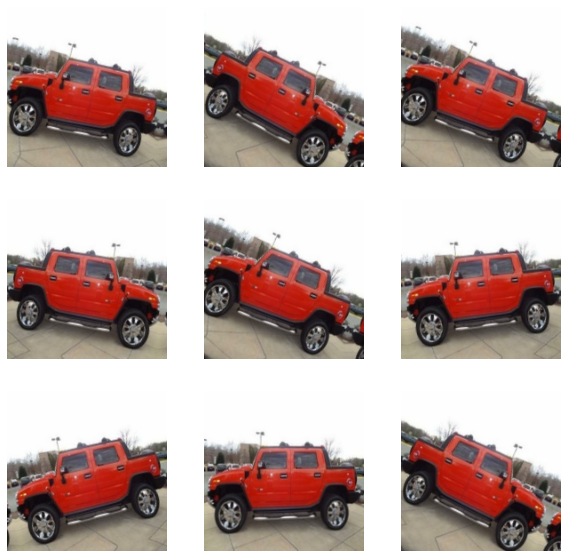

In [73]:
plt.figure(figsize = (10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3, i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [74]:
rain_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size = 32)

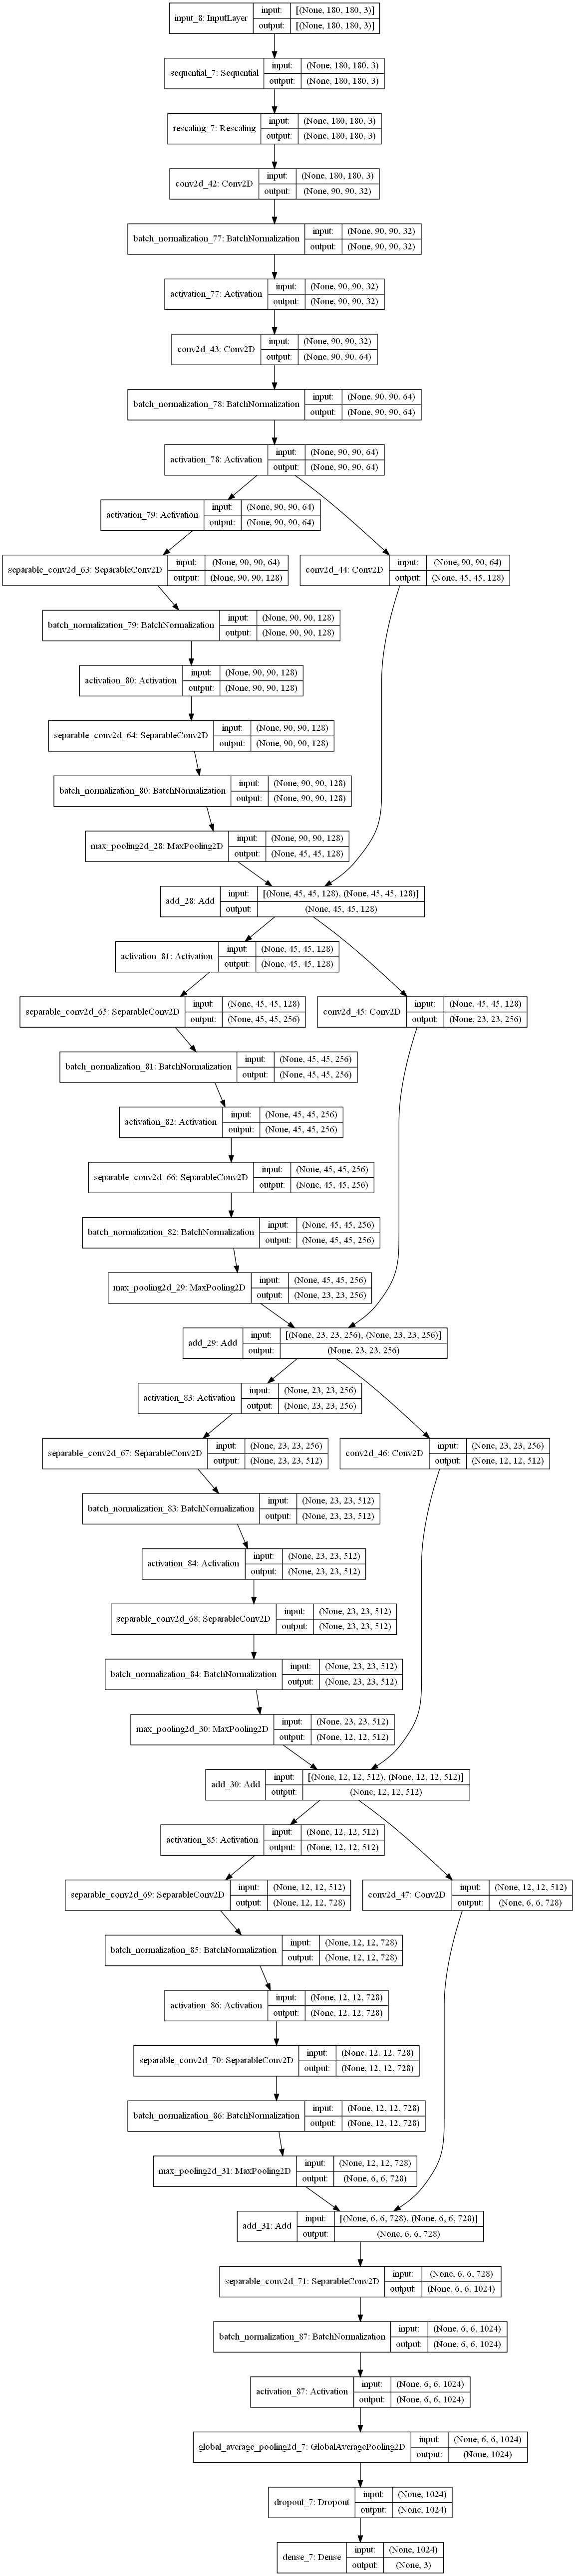

In [75]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape = input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)
    
    # Entry block
    x = layers.Rescaling(1.0/255)(x)
    x = layers.Conv2D(32, 3, strides = 2, padding = "same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activatoin = x # set aside residual

    for size in [128, 256, 512, 728]: 
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding = "same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides = 2, padding = "same")(x)

        # Project resdual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activatoin
        )
        x = layers.add([x, residual]) # Add back residual
        previous_block_activatoin = x # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else: 
        activation = "softmax"
        units = num_classes
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation = activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape = image_size + (3,), num_classes=3)
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [76]:
epochs = 6

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
print("complited Callbacks")
model.compile(
    optimizer = keras.optimizers.Adam(1e-3),
    loss = "sparse_categorical_crossentropy",   
    metrics = ["accuracy"],  
)
print("model compiled")
model.fit(
    train_ds, epochs=epochs, callbacks = callbacks, validation_data=val_ds,    
)
model.save('D:\SJSU_HW\GitHubSJSU\Vehicles_Training_Tensorflow')
print("model saved hopefully.")

complited Callbacks
model compiled
Epoch 1/6
27/27 [==============================] - 140s 5s/step - loss: 1.0165 - accuracy: 0.5654 - val_loss: 1.0967 - val_accuracy: 0.4526
Epoch 2/6
27/27 [==============================] - 136s 5s/step - loss: 0.8098 - accuracy: 0.6612 - val_loss: 1.1263 - val_accuracy: 0.1474
Epoch 3/6
27/27 [==============================] - 140s 5s/step - loss: 0.7232 - accuracy: 0.7021 - val_loss: 1.2375 - val_accuracy: 0.1474
Epoch 4/6
27/27 [==============================] - 139s 5s/step - loss: 0.6084 - accuracy: 0.7442 - val_loss: 1.3093 - val_accuracy: 0.1474
Epoch 5/6
27/27 [==============================] - 141s 5s/step - loss: 0.5548 - accuracy: 0.7886 - val_loss: 1.4620 - val_accuracy: 0.1474
Epoch 6/6
27/27 [==============================] - 138s 5s/step - loss: 0.4782 - accuracy: 0.8143 - val_loss: 1.7050 - val_accuracy: 0.1474
INFO:tensorflow:Assets written to: D:\SJSU_HW\GitHubSJSU\Vehicles_Training_Tensorflow\assets
model saved hopefully.


c:\venvTF\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
